<a href="https://colab.research.google.com/github/Paushi2003/Farmland-segmentation-using-satellite-image-data/blob/main/Farmland_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install segment-geospatial leafmap localtileserver

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import os
import leafmap
from samgeo import SamGeo, show_image, download_file, overlay_images, tms_to_geotiff
from zipfile import ZipFile

In [ ]:
m = leafmap.Map(center=[12.31069, 78.18809], zoom=17, height="800px")
m.add_basemap("SATELLITE")
m

Map(center=[12.31069, 78.18809], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

In [ ]:
if m.user_roi_bounds() is not None:
    bbox = m.user_roi_bounds()
else:
    bbox = [12.31069, 78.18809, 12.30069, 78.18709]

In [ ]:
image = "satellite.tif"
tms_to_geotiff(output=image, bbox=bbox, zoom=17, source="Satellite", overwrite=True)

Downloaded image 1/6
Downloaded image 2/6
Downloaded image 3/6
Downloaded image 4/6
Downloaded image 5/6
Downloaded image 6/6
Saving GeoTIFF. Please wait...
Image saved to satellite.tif


In [ ]:
import cv2
image = cv2.imread('satellite.tif')
cv2.imwrite("{}.jpg".format('converted'), image)

True

In [ ]:
m.layers[-1].visible = False
m.add_raster(image, layer_name="Image")
m

In [ ]:
sam = SamGeo(
    model_type="vit_h",
    checkpoint='sam_vit_h_4b8939.pth',
    sam_kwargs=None,
)

Checkpoint /root/.cache/torch/hub/checkpoints/sam_vit_h_4b8939.pth does not exist.


Downloading...
From: https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
To: /root/.cache/torch/hub/checkpoints/sam_vit_h_4b8939.pth
100%|██████████| 2.56G/2.56G [00:10<00:00, 248MB/s]


In [ ]:
sam.generate(image, output="masks.tif", foreground=True, unique=True)

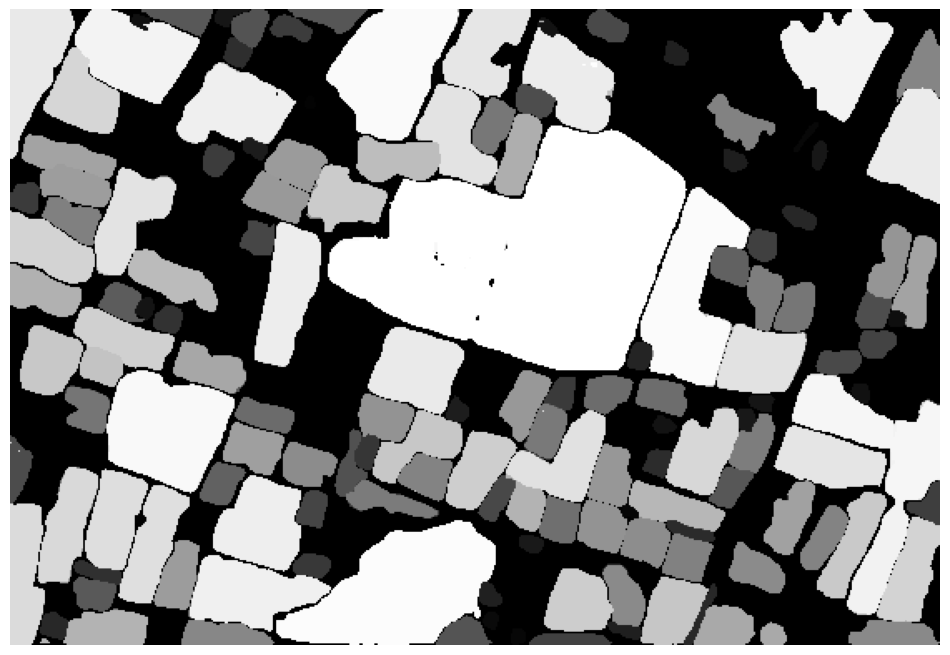

In [ ]:
sam.show_masks(cmap="binary_r")


In [ ]:
sam.tiff_to_vector("masks.tif", "masks.shp")

In [ ]:
sam.show_anns(axis="off", alpha=1, output="annotations.tif")


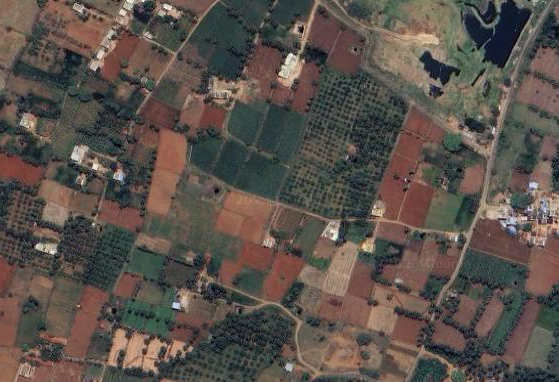
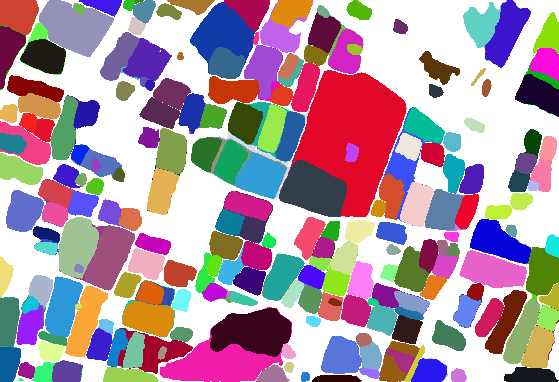

In [ ]:
#comparing image with sliders
leafmap.image_comparison(
    "satellite.tif",
    "annotations.tif",
    label1="Satellite Image",
    label2="Image Segmentation",
)

Creation of frontend using Gradio

In [ ]:
!pip install segment-geospatial leafmap localtileserver
!pip install gradio

In [ ]:
import gradio as gr
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import os
import leafmap
from samgeo import SamGeo, show_image, download_file, overlay_images, tms_to_geotiff
from zipfile import ZipFile


#initialize the model
sam = SamGeo(
    model_type="vit_h",
    checkpoint='sam_vit_h_4b8939.pth',
    sam_kwargs=None,
)

def get_all_file_paths(directory):

    # initializing empty file paths list
    file_paths = []

    # crawling through directory and subdirectories
    for root, directories, files in os.walk(directory):
        for filename in files:
            # join the two strings in order to form the full filepath.
            filepath = os.path.join(root, filename)
            file_paths.append(filepath)

    # returning all file paths
    return file_paths

def get_shape_files(image):
  filename, file_extension = os.path.splitext(image.name)
  # print(filename,file_extension)
  if file_extension in ['.tif','tiff']:
    #mkdir for app
    storage='app_store'
    if os.path.exists(storage):
        pass
    else:
      os.mkdir(storage)

    zip_folder=f'{storage}/zip_folder'
    if os.path.exists(zip_folder):
        pass
    else:
      os.mkdir(zip_folder)

    out_file=f'{storage}/out_files'
    if os.path.exists(out_file):
        pass
    else:
      os.mkdir(out_file)

    # load_model()
    sam.generate(image.name, output=f"{out_file}/masks.tif", foreground=True, unique=True)
    sam.tiff_to_vector(f"{out_file}/masks.tif", out_file)
    sam.show_anns(axis="off", alpha=1, output=f"{out_file}/annotations.tif")

    #converting tif to jpg
    image = cv2.imread(f"{out_file}/annotations.tif")
    cv2.imwrite("{}/{}.jpg".format(out_file,'converted'), image)

    # writing files to a zipfile
    file_paths=get_all_file_paths(out_file)

    # for file_name in file_paths:
    #       print(file_name)

    with ZipFile(f'{zip_folder}/shapefile.zip','w') as zip:
        # writing each file one by one
        for file in file_paths:
            zip.write(file)

    print('All files zipped successfully!')

    return f"{out_file}/converted.jpg",f'{zip_folder}/shapefile.zip'
  # get_shape_files(image)
  else:
    return "Try uploading .tif file for processing!."

my_app = gr.Blocks()
with my_app:
  gr.Markdown("<center><h1>Farmland Segmentation using Satellite Image data</h1></center>")
  gr.Markdown("<center><h3>Provided with a .tif image file of satellite info, this app can segment the farmlands</h></center>")
  with gr.TabItem("Get Shapefiles"):
    with gr.Row():
      with gr.Column():
          img_source = gr.File(label="Please select source tif")
          source_image_loader = gr.Button("Get Shape File")
      with gr.Column():
          image=gr.Image()
          output = gr.outputs.File("zip")
  source_image_loader.click(get_shape_files,img_source,[image,output])
my_app.launch(debug = True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

All files zipped successfully!
Keyboard interruption in main thread... closing server.
